
Stationarity Tests:
ADF Test for AAPL
ADF Statistic: -0.4296
p-value: 0.9050
AAPL is non-stationary (has unit root)
----------------------------------------
ADF Test for MSFT
ADF Statistic: 0.7453
p-value: 0.9907
MSFT is non-stationary (has unit root)
----------------------------------------
ADF Test for GOOGL
ADF Statistic: 0.0164
p-value: 0.9599
GOOGL is non-stationary (has unit root)
----------------------------------------
ADF Test for AMZN
ADF Statistic: -0.4648
p-value: 0.8987
AMZN is non-stationary (has unit root)
----------------------------------------
ADF Test for META
ADF Statistic: 0.6878
p-value: 0.9896
META is non-stationary (has unit root)
----------------------------------------

Cointegration Analysis:
Cointegration Test: AAPL vs MSFT
Test Statistic: -2.2735
p-value: 0.3869
No evidence of cointegration between AAPL and MSFT
----------------------------------------
Cointegration Test: AAPL vs GOOGL
Test Statistic: -2.1709
p-value: 0.4394
No evidence of cointegration be

/tmp/ipykernel_2558343/904839191.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


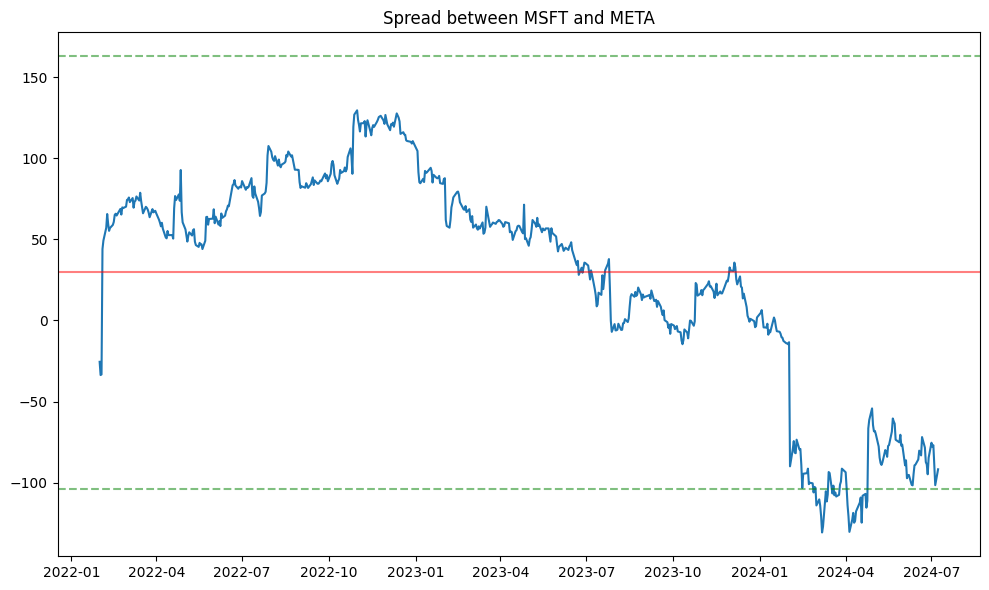

----------------------------------------
Cointegration Test: GOOGL vs AMZN
Test Statistic: -2.8964
p-value: 0.1369
No evidence of cointegration between GOOGL and AMZN
----------------------------------------
Cointegration Test: GOOGL vs META
Test Statistic: -2.1641
p-value: 0.4430
No evidence of cointegration between GOOGL and META
----------------------------------------
Cointegration Test: AMZN vs META
Test Statistic: -2.0892
p-value: 0.4820
No evidence of cointegration between AMZN and META
----------------------------------------

Summary of Cointegrated Pairs:
  Stock1 Stock2   p-value
0   MSFT   META  0.000953


<Figure size 1200x800 with 0 Axes>

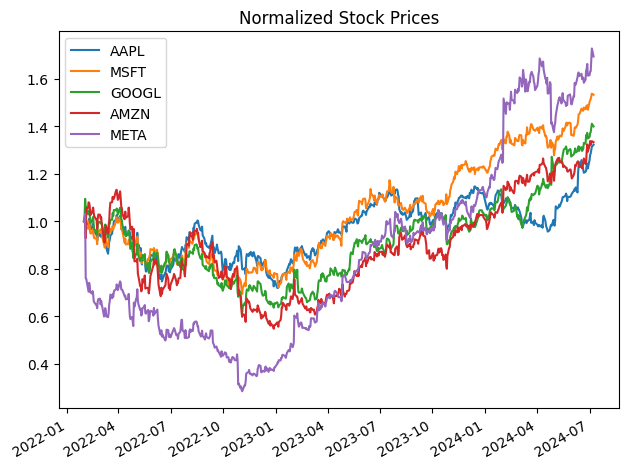

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
from datetime import datetime, timedelta
from quant_free.dataset.us_equity_load import *

def download_stock_data(tickers, period='2y'):
    """Download stock data for the given tickers"""
    start_date = '2022-01-29'
    end_date = '2024-07-08'
    market='us'

    data = equity_tradedata_load_bt_dates(
                                              market=market,
                                              symbols = tickers, 
                                              start_date = start_date, 
                                              end_date = end_date, 
                                              dir_option = 'xq', 
                                              column_option = 'close')

    return pd.DataFrame(data)

def test_stationarity(series, ticker_name):
    """Test if a time series is stationary using ADF test"""
    result = adfuller(series.dropna())
    print(f"ADF Test for {ticker_name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    
    if result[1] > 0.05:
        print(f"{ticker_name} is non-stationary (has unit root)")
    else:
        print(f"{ticker_name} is stationary")
    print("-" * 40)
    
    return result[1] > 0.05

def check_cointegration_pair(stock1, stock2, stock1_name, stock2_name):
    """Check cointegration between two stock price series"""
    # Ensure same length
    common_index = stock1.index.intersection(stock2.index)
    s1 = stock1.loc[common_index]
    s2 = stock2.loc[common_index]
    
    # Drop NAs
    mask = ~(np.isnan(s1) | np.isnan(s2))
    s1 = s1[mask]
    s2 = s2[mask]
    
    # Perform cointegration test
    score, pvalue, _ = coint(s1, s2)
    
    print(f"Cointegration Test: {stock1_name} vs {stock2_name}")
    print(f"Test Statistic: {score:.4f}")
    print(f"p-value: {pvalue:.4f}")
    
    if pvalue < 0.05:
        print(f"{stock1_name} and {stock2_name} are cointegrated")
        # Calculate hedge ratio
        model = OLS(s1, s2).fit()
        hedge_ratio = model.params[0]
        print(f"Hedge ratio: {hedge_ratio:.4f}")
        
        # Plot the spread
        spread = s1 - hedge_ratio * s2
        plt.figure(figsize=(10, 6))
        plt.plot(spread)
        plt.title(f"Spread between {stock1_name} and {stock2_name}")
        plt.axhline(y=spread.mean(), color='r', linestyle='-', alpha=0.5)
        plt.axhline(y=spread.mean() + 2*spread.std(), color='g', linestyle='--', alpha=0.5)
        plt.axhline(y=spread.mean() - 2*spread.std(), color='g', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No evidence of cointegration between {stock1_name} and {stock2_name}")
    
    print("-" * 40)
    return pvalue < 0.05, pvalue

def find_cointegrated_pairs(data, significance=0.05):
    """Find all cointegrated pairs in a DataFrame of stock prices"""
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    # Format for storing results
    results = []
    
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            stock1_name = data.columns[i]
            stock2_name = data.columns[j]
            
            is_coint, pvalue = check_cointegration_pair(stock1, stock2, stock1_name, stock2_name)
            
            pvalue_matrix[i, j] = pvalue
            
            if is_coint:
                pairs.append((stock1_name, stock2_name))
                results.append({
                    'Stock1': stock1_name,
                    'Stock2': stock2_name,
                    'p-value': pvalue
                })
    
    return pairs, pvalue_matrix, pd.DataFrame(results)

def main():
    # Example: Testing for cointegration between stocks
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
    
    print(f"Downloading data for {tickers}...")
    data = download_stock_data(tickers)
    
    # Check stationarity of each stock
    print("\nStationarity Tests:")
    for ticker in tickers:
        test_stationarity(data[ticker], ticker)
    
    # Find all cointegrated pairs
    print("\nCointegration Analysis:")
    pairs, pvalue_matrix, results_df = find_cointegrated_pairs(data)
    
    print("\nSummary of Cointegrated Pairs:")
    if len(pairs) > 0:
        print(results_df.sort_values('p-value'))
    else:
        print("No cointegrated pairs found")
    
    # Plot all stock prices (normalized)
    plt.figure(figsize=(12, 8))
    normalized_data = data / data.iloc[0]  # Normalize to starting point
    normalized_data.plot()
    plt.title('Normalized Stock Prices')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()